In [2]:
import os
# os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from IPython.display import Image as IPyImage, display
from io import BytesIO
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [3]:
# device = torch.device("mps")
device = torch.device("cpu")


In [4]:
device

device(type='cpu')

In [5]:
class ConvLSTMUnit(nn.Module):
    def __init__(self, inChannels, hiddenChannels, kernel_size):
        super().__init__()
        padd = kernel_size//2

        # the output is of the size of LSTM INPUT (INPUT, FORGET, CONTEXT, OUTPUT)
        self.convUnit = nn.Conv2d(
            in_channels=inChannels+hiddenChannels,
            out_channels= 4 * hiddenChannels,
            kernel_size=kernel_size,
            padding=padd, 
        )

    def forward(self, x, hiddenState):
        hidden, context = hiddenState
        combined_channel = torch.cat([x, hidden], dim=1)
        # print("For Debugging Combined Concatenates: ", combined_channel.shape)
        lstm_inputs = self.convUnit(combined_channel)
        # print("CONV OutS: ", lstm_inputs.shape)

        inputGate, forgetGate, candidateGate, outputGate = torch.chunk(lstm_inputs, chunks=4, dim=1)

        inputGate = torch.sigmoid(inputGate)
        forgetGate = torch.sigmoid(forgetGate)
        candidateGate = torch.tanh(candidateGate)
        outputGate = torch.sigmoid(outputGate)

        context_next = forgetGate * context + inputGate * candidateGate
        hidden_next = outputGate * torch.tanh(context_next)
        # print("HiDDen Next: ", hidden_next.shape)
        # print("CoNText Next: ", context_next.shape)
        return hidden_next, (hidden_next, context_next)
    

convlstmUnit = ConvLSTMUnit(inChannels=1, hiddenChannels=32, kernel_size=3)

test = torch.randn(1, 1, 64, 64)
hidden = torch.zeros(1, 32, 64, 64)
context = torch.zeros(1, 32, 64, 64)
out = convlstmUnit(test, (hidden, context))
out[0].shape

torch.Size([1, 32, 64, 64])

In [6]:
class VideoGenerator(nn.Module):
    def __init__(self, inChannels, hiddenChannels, outChannels):
        super().__init__()

        self.inChannels = inChannels
        self.hiddenChannels = hiddenChannels
        self.outChannels = outChannels
        self.encoderLayer = nn.Sequential(
            nn.Conv2d(in_channels=inChannels, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.convLSTMUnit = ConvLSTMUnit(64, hiddenChannels=hiddenChannels, kernel_size=3)

        self.decoderLayer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hiddenChannels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=outChannels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, num_future_frames = 10):
        batch_size, timeStamps, channel, height, width = x.shape
        x = x.view(batch_size * timeStamps, channel, height, width)
        x = self.encoderLayer(x)

        _, channel_encoder, height_encoder, width_encoder = x.shape
        x = x.view(batch_size, timeStamps, channel_encoder, height_encoder, width_encoder)

        hidden = torch.zeros(batch_size, self.hiddenChannels, height_encoder, width_encoder, device=x.device)
        context = torch.zeros(batch_size, self.hiddenChannels, height_encoder, width_encoder, device=x.device)
        
        hidden_state = (hidden, context)
        
        for each_timestamp in range(timeStamps):
            h, hidden_state = self.convLSTMUnit(x[:, each_timestamp], hidden_state)

        last_encoded_frame = x[:, -1]

        generated_frames = []

        input_frame = last_encoded_frame
        for _ in range(num_future_frames):
            h, hidden_state = self.convLSTMUnit(input_frame, hidden_state)
            gen_frame = self.decoderLayer(h)
            generated_frames.append(gen_frame)
            input_frame = self.encoderLayer(gen_frame)

        return torch.stack(generated_frames, dim=1)


videoModel = VideoGenerator(1, 32, 1)
test = torch.randn(1, 20, 1, 64, 64)
out = videoModel(test)
out.shape

torch.Size([1, 10, 1, 64, 64])

In [7]:
data = np.load("data/MovingMNIST/mnist_test_seq.npy")
data.shape

(20, 10000, 64, 64)

In [8]:
data = np.transpose(data, (1, 0, 2, 3))
data.shape

(10000, 20, 64, 64)

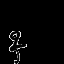

In [9]:
def visualizeData(sequence):

    frames = [Image.fromarray((frame * 255).astype(np.uint8), mode='L') for frame in sequence]

    buffer = BytesIO()
    frames[0].save(
        buffer,
        format='GIF',
        save_all=True,
        append_images=frames[1:],
        duration=100,
        loop=0
    )

    buffer.seek(0)
    display(IPyImage(data=buffer.getvalue()))

visualizeData(data[11])

In [10]:
data = torch.from_numpy(data)
data.shape, type(data)

(torch.Size([10000, 20, 64, 64]), torch.Tensor)

In [11]:
X = data[:, :10, :, :]
Y = data[:, 10:, :, :]
print(X.shape, Y.shape)

torch.Size([10000, 10, 64, 64]) torch.Size([10000, 10, 64, 64])


In [ ]:
tensorData = TensorDataset(X, Y)
dataloader = DataLoader(tensorData, batch_size=32, shuffle=True)
dataloader

In [13]:
model = VideoGenerator(inChannels=1, hiddenChannels=32, outChannels=1)
model.to(device)
lossFn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
epochs = 10

In [39]:
from fvd import frechet_distance

rand1 = torch.randn(64, 64)
rand2 = torch.randn(64, 64)

frechet_distance(rand1, rand2)

36.76788330078125

In [97]:
for each_epoch in range(epochs):
    loop = tqdm(dataloader, f"{each_epoch}/{epochs}")
    lossVal = 0.0
    for batchX, batchY in loop:
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        batchX = batchX.unsqueeze(2)
        # batchY = batchY.unsqueeze(2)
        batchX = batchX/255.0
        batchY = batchY/255.0

        # print(batchX.shape)
        pred = model(batchX).squeeze()
        # print(pred.shape, batchY.shape)

        optimizer.zero_grad()
        loss = lossFn(pred, batchY)
        loss.backward()
        optimizer.step()

        lossVal += loss.item()

    avg_loss = lossVal/len(dataloader)
    print(f" The Loss is {avg_loss}")
    # loop.postfix()
    torch.save(model.state_dict(), "data/model.pt")
    

        # break

    # break



0/10: 100%|██████████| 79/79 [56:33<00:00, 42.96s/it]


 The Loss is 0.1179346286609203


1/10: 100%|██████████| 79/79 [55:15<00:00, 41.97s/it]


 The Loss is 0.04207465924982783


2/10: 100%|██████████| 79/79 [55:26<00:00, 42.11s/it]


 The Loss is 0.041164300298389


3/10: 100%|██████████| 79/79 [57:20<00:00, 43.55s/it]


 The Loss is 0.03969048718108407


4/10: 100%|██████████| 79/79 [1:20:30<00:00, 61.15s/it] 


 The Loss is 0.03788648941848852


5/10: 100%|██████████| 79/79 [58:35<00:00, 44.50s/it]


 The Loss is 0.03740830695893191


6/10: 100%|██████████| 79/79 [58:44<00:00, 44.61s/it]


 The Loss is 0.03705621562615226


7/10: 100%|██████████| 79/79 [58:41<00:00, 44.58s/it]


 The Loss is 0.03672262724441818


8/10: 100%|██████████| 79/79 [58:29<00:00, 44.42s/it]


 The Loss is 0.0365277731531783


9/10: 100%|██████████| 79/79 [6:59:11<00:00, 318.38s/it]    

 The Loss is 0.03640020360486417


In [22]:
modelVal = torch.load("data/model_15-5.pt")
model.load_state_dict(modelVal)

<All keys matched successfully>

In [23]:
initial = data[0, 0]
initial = initial.unsqueeze(0).unsqueeze(0).unsqueeze(2)
initial.shape

torch.Size([1, 1, 1, 64, 64])

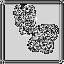

In [25]:
def generateVideos(model, initialFrame):

    all_outputs = []

    test = initialFrame.float().unsqueeze(0).unsqueeze(0).unsqueeze(2)  

    for _ in range(2):
        out = model(test)
        # print(out.shape)
        temp = out * 255.0
        all_outputs.append(temp)
        last_frame = out[:, -1, :, :]
        test = last_frame.unsqueeze(1)
        # print(test.shape)

    full_output = torch.cat(all_outputs, dim=1)
    full_output = full_output.squeeze(2)
    # print(full_output.shape)
    numpy_data = full_output.detach().cpu().numpy()
    visualizeData(numpy_data[0])

initial_frame = data[0, 15]/255.0

generateVideos(model, initial_frame)